# Importing libraries


In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable
from collections import deque
import random
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import warnings
warnings.filterwarnings("ignore")
import sys
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plotting functions

In [47]:
def plot_mean_variance_plot(rewards1,rewards2 = None,env_id=None,baseline=None):

  # change rewards2 if you want comparitive plot between rewards1 and rewards2.
  # Otherwise it will just plot mean and variance plot for rewards1.
  rewards1 = np.array(rewards1)
  mean_rewards1 = rewards1.mean(axis=0)
  std_rewards1 = rewards1.std(axis=0)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  x = np.arange(1, len(mean_rewards1)+1)
  if rewards2:
    rewards2 = np.array(rewards2)
    mean_rewards2 = rewards2.mean(axis=0)
    std_rewards2 = rewards2.std(axis=0)
    ax.plot(x, mean_rewards1, '-',label = "with Baseline",color='red')
    ax.fill_between(x, mean_rewards1 - std_rewards1, mean_rewards1 + std_rewards1, color='red', alpha=0.2)
    ax.plot(x, mean_rewards2, '-',label = "without Baseline",color='blue')
    ax.fill_between(x, mean_rewards2 - std_rewards2, mean_rewards2 + std_rewards2, color='blue', alpha=0.2)
    plt.ylabel('Rewards')
    plt.xlabel('Episode #')
    plt.title(f'Comparitive performance of MC REINCFORCE in {env_id} w/ & w/o Baseline averaged over 5 seeds')
    plt.legend()
    plt.show()
  else:
    ax.plot(x, mean_rewards1, '-', color='red')
    ax.fill_between(x, mean_rewards1 - std_rewards1, mean_rewards1+ std_rewards1, color='blue', alpha=0.2)
    plt.ylabel('Rewards')
    plt.xlabel('Episode #')
    if baseline:
      plt.title(f'MC REINCFORCE in {env_id} with Baseline update averaged over 5 seeds')
    else:
      plt.title(f'MC REINCFORCE in {env_id} without Baseline update averaged over 5 seeds')
    plt.show()

# Policy & Value networks

In [21]:
class policy_net(nn.Module):
  def __init__(self, state_space, hidden_size, action_space):
        super(policy_net, self).__init__()
        self.fc1 = nn.Linear(state_space, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_space)

  def forward(self, inputs):
    # estimating the policy for selecting the action
    x = F.relu(self.fc1(inputs))
    action_scores = self.fc2(x)
    return F.softmax(action_scores,dim=1)

  def select_action(self,state):
    # selecting the action using the policy net
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = self.forward(state).cpu()
    m = Categorical(probs)
    act = m.sample()
    return act.item(),m.log_prob(act)

class value_net(nn.Module):
  def __init__(self, state_space, hidden_size):
        super(value_net, self).__init__()
        self.fc1 = nn.Linear(state_space, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

  def forward(self, state):
    # value_network for estimating the state value function
    x = F.relu(self.fc1(state))
    val = self.fc2(x)
    return val

# Required Functions

In [22]:
# calculating the estimated returns using this function
def calculate_returns(rewards,gamma,baseline):
    returns  = []
    discounted_rewards= []
    total_r = 0
    for r in reversed(rewards):
      total_r = r + total_r *gamma
      returns.insert(0, total_r)
      discounted_rewards.append(total_r)

    if baseline:
      returns = torch.tensor(returns).to(device)
      returns = (returns- returns.mean())/returns.std()
      return returns
    else:
      returns = torch.tensor(discounted_rewards).to(device)
      return torch.flip(returns,[0])

In [24]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

# Main Algorithm

In [64]:
max_episodes = 2000
max_steps = 1000
def run_experiment(env_id,baseline,seed=42,lr1=3e-4,lr2=1e-4,gamma=0.99,hidden_size=128,print_flag=True,plot_flag=True):
  # create the gym environment
  env = gym.make(env_id)
  n_state = env.observation_space.shape[0]
  n_action = env.action_space.n

  # creating random environments for stochasticity
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  env.seed(seed)

  # defining the policy and value networks and corresponding optimizers
  policy_network = policy_net(env.observation_space.shape[0],hidden_size, env.action_space.n).to(device)
  value_network = value_net(env.observation_space.shape[0],hidden_size).to(device)
  policy_network.apply(init_weights)
  value_network.apply(init_weights)
  policy_optimizer = optim.Adam(policy_network.parameters(), lr=lr1)
  value_optimizer = optim.Adam(value_network.parameters(), lr=lr2)

  # scores => keeps track of episodic rewards
  # average scores => moving average of last 10 episodic rewards
  # past_scores_deq => keeps track of last 100 episodic rewards to print their mean
  scores = []
  avg_scores = []
  past_scores_deq = deque(maxlen = 100)
  for episode in range(max_episodes):
    states = []
    rewards  = []
    saved_log_probs = []
    state = env.reset()
    for step in range(max_steps):
      #selecting the action
      act,ln_prob = policy_network.select_action(np.array(state))

      #saving the states,log probabs
      saved_log_probs.append(ln_prob)
      states.append(state)
      next_state,reward,done,_ = env.step(act)

      # saving the rewards
      rewards.append(reward)
      if done:
        break
      state = next_state

    scores.append(sum(rewards))
    avg_scores.append(np.mean(scores[-10:]))
    past_scores_deq.append(sum(rewards))

    # if we run the algorithm with baseline
    if baseline:

      # calculating the estimated returns for the current episode
      returns = calculate_returns(rewards,gamma,baseline)

      # calculating the estimated state value functions for the current episode
      estimated_vals = []
      for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        estimated_vals.append(value_network(state))
      estimated_vals = torch.stack(estimated_vals).squeeze()

      # updating the state value network
      val_loss = F.mse_loss(estimated_vals,returns)
      value_optimizer.zero_grad()
      val_loss.backward()
      value_optimizer.step()


      # calculating the delta = G_t - V(S,w)
      deltas = []
      for ret,val in zip(returns,estimated_vals):
        deltas.append(ret-val)
      deltas = torch.tensor(deltas).to(device)


      # updating the policy network
      policy_loss = []
      for d, lp in zip(deltas,saved_log_probs):
        policy_loss.append(-d * lp)

      policy_loss = torch.cat(policy_loss).sum()
      policy_optimizer.zero_grad()
      policy_loss.backward()
      policy_optimizer.step()

    # algorithm with no baseline
    else:
      # calculating the returns for this episode
      returns = calculate_returns(rewards,gamma,baseline=False)

      # updating the policy network
      policy_loss = []
      for d, lp in zip(returns,saved_log_probs):
        policy_loss.append(-d * lp)

      policy_loss = torch.cat(policy_loss).sum()
      policy_optimizer.zero_grad()
      policy_loss.backward()
      policy_optimizer.step()

    if print_flag and episode%100==0:
      sys.stdout.write('Episode {}\tAverage Score: {:.2f}'.format(episode, np.mean(past_scores_deq)))

  sys.stdout.write("Experiment completed! Rewards recorded!\n")
  if plot_flag:
    plt.plot(scores)
    plt.plot(avg_scores)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

  return scores,avg_scores

# Test run on both environments

In [31]:
env_id = "Acrobot-v1"
lr1 = 1e-3
lr2 = 1e-3
hidden_size = 32

Episode 0	Average Score: -500.00
Episode 100	Average Score: -433.67
Episode 200	Average Score: -169.92
Episode 300	Average Score: -144.49
Episode 400	Average Score: -130.55
Episode 500	Average Score: -121.08
Episode 600	Average Score: -119.01
Episode 700	Average Score: -114.56
Episode 800	Average Score: -112.15
Episode 900	Average Score: -105.35
Episode 1000	Average Score: -107.33
Episode 1100	Average Score: -100.87
Episode 1200	Average Score: -100.25
Episode 1300	Average Score: -95.21
Episode 1400	Average Score: -90.93
Episode 1500	Average Score: -101.51
Episode 1600	Average Score: -87.88
Episode 1700	Average Score: -92.99
Episode 1800	Average Score: -87.76
Episode 1900	Average Score: -90.37


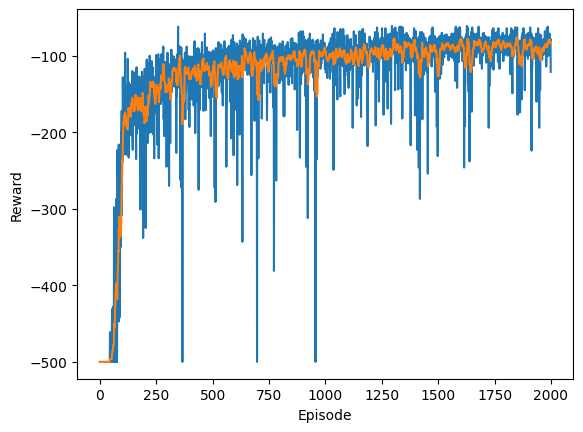

In [32]:
acrobat_rewards_baseline,acrobat_avg_rewards_baseline = run_experiment(env_id,baseline = True,seed = 42,lr1 = lr1,lr2=lr2)

Episode 0	Average Score: -500.00
Episode 100	Average Score: -413.53
Episode 200	Average Score: -179.44
Episode 300	Average Score: -141.26
Episode 400	Average Score: -120.61
Episode 500	Average Score: -128.05
Episode 600	Average Score: -129.69
Episode 700	Average Score: -130.96
Episode 800	Average Score: -120.21
Episode 900	Average Score: -114.24
Episode 1000	Average Score: -121.14
Episode 1100	Average Score: -109.52
Episode 1200	Average Score: -105.59
Episode 1300	Average Score: -113.21
Episode 1400	Average Score: -113.43
Episode 1500	Average Score: -116.72
Episode 1600	Average Score: -119.17
Episode 1700	Average Score: -114.50
Episode 1800	Average Score: -109.25
Episode 1900	Average Score: -111.05


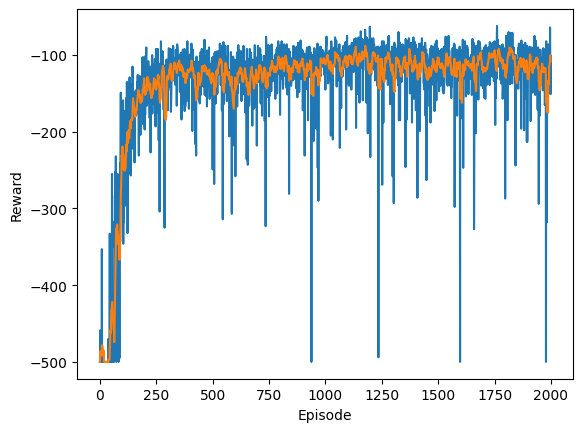

In [33]:
acrobat_rewards_no_baseline,acrobat_avg_rewards_no_baseline = run_experiment(env_id,baseline = False,seed = 42,lr1 = lr1,lr2=lr2)

In [34]:
env_id = "CartPole-v1"
lr1 = 1e-3
lr2 = 1e-3
hidden_size = 32

Episode 0	Average Score: 16.00
Episode 100	Average Score: 32.84
Episode 200	Average Score: 62.15
Episode 300	Average Score: 229.16
Episode 400	Average Score: 384.68
Episode 500	Average Score: 485.70
Episode 600	Average Score: 475.00
Episode 700	Average Score: 491.95
Episode 800	Average Score: 481.22
Episode 900	Average Score: 499.23
Episode 1000	Average Score: 496.29
Episode 1100	Average Score: 496.35
Episode 1200	Average Score: 494.36
Episode 1300	Average Score: 498.20
Episode 1400	Average Score: 492.52
Episode 1500	Average Score: 463.47
Episode 1600	Average Score: 446.32
Episode 1700	Average Score: 485.11
Episode 1800	Average Score: 500.00
Episode 1900	Average Score: 495.71


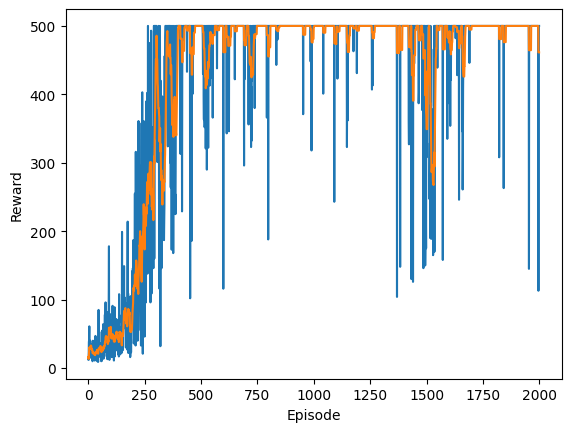

In [35]:
cartpole_rewards_baseline,cartpole_avg_rewards_baseline = run_experiment(env_id,baseline = True,seed = 42,lr1 = lr1,lr2=lr2)

Episode 0	Average Score: 16.00
Episode 100	Average Score: 25.81
Episode 200	Average Score: 69.21
Episode 300	Average Score: 149.52
Episode 400	Average Score: 323.20
Episode 500	Average Score: 341.29
Episode 600	Average Score: 428.31
Episode 700	Average Score: 460.54
Episode 800	Average Score: 419.22
Episode 900	Average Score: 430.71
Episode 1000	Average Score: 432.65
Episode 1100	Average Score: 482.73
Episode 1200	Average Score: 488.76
Episode 1300	Average Score: 486.15
Episode 1400	Average Score: 469.67
Episode 1500	Average Score: 490.85
Episode 1600	Average Score: 448.86
Episode 1700	Average Score: 475.59
Episode 1800	Average Score: 476.66
Episode 1900	Average Score: 495.33


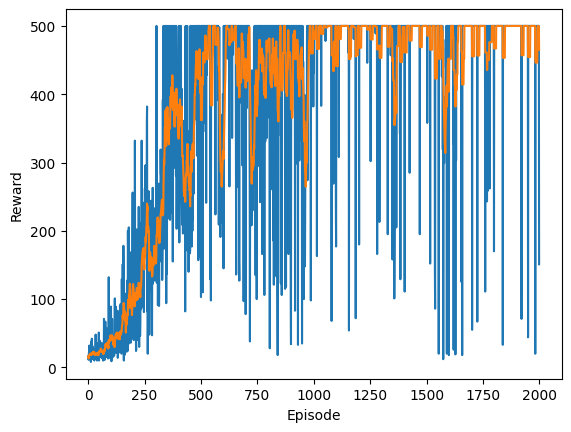

In [36]:
cartpole_rewards_no_baseline,cartpole_avg_rewards_no_baseline = run_experiment(env_id,baseline = False,seed = 42,lr1 = lr1,lr2=lr2)

## Experiments

# Acrobot

In [65]:
#hyperparameteres
env_id = "Acrobot-v1"
lr1 = 1e-3
lr2 = 1e-3
hidden_size = 32
max_episodes = 1500
max_steps = 1000

In [54]:
#running 5 experiments.
np.random.seed(42)
seeds = np.random.randint(1000, size=5)
acrobot_baseline_scores = []
acrobot_baseline_avg_scores = []
exp = 1
for seed in seeds:
  print(f"Experiment {exp} => Training started\n")
  rewards,avg_rewards = run_experiment(env_id,baseline = True,seed = int(seed),lr1 = lr1,lr2=lr2,print_flag=False,plot_flag = False)
  acrobot_baseline_scores.append(rewards)
  acrobot_baseline_avg_scores.append(avg_rewards)
  exp+=1

Experiment 1 => Training started

Experiment completed! Rewards recorded!
Experiment 2 => Training started

Experiment completed! Rewards recorded!
Experiment 3 => Training started

Experiment completed! Rewards recorded!
Experiment 4 => Training started

Experiment completed! Rewards recorded!
Experiment 5 => Training started

Experiment completed! Rewards recorded!


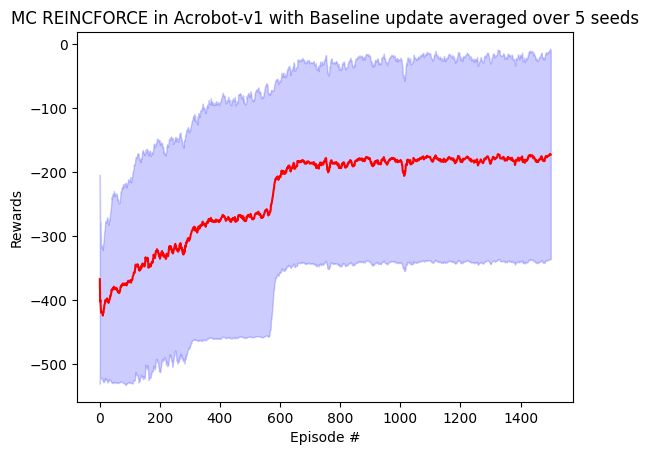

In [55]:
plot_mean_variance_plot(acrobot_baseline_avg_scores,env_id=env_id,baseline=True)

In [66]:
#running 5 experiments.
np.random.seed(42)
seeds = np.random.randint(1000, size=5)
acrobot_no_baseline_scores = []
acrobot_no_baseline_avg_scores = []
exp = 1
for seed in seeds:
  print(f"Experiment {exp} => Training started\n")
  rewards,avg_rewards = run_experiment(env_id,baseline = False ,seed = int(seed),lr1 = lr1,lr2=lr2,print_flag=False,plot_flag = False)
  acrobot_no_baseline_scores.append(rewards)
  acrobot_no_baseline_avg_scores.append(avg_rewards)
  exp+=1

Experiment 1 => Training started

Experiment completed! Rewards recorded!
Experiment 2 => Training started

Experiment completed! Rewards recorded!
Experiment 3 => Training started

Experiment completed! Rewards recorded!
Experiment 4 => Training started

Experiment completed! Rewards recorded!
Experiment 5 => Training started

Experiment completed! Rewards recorded!


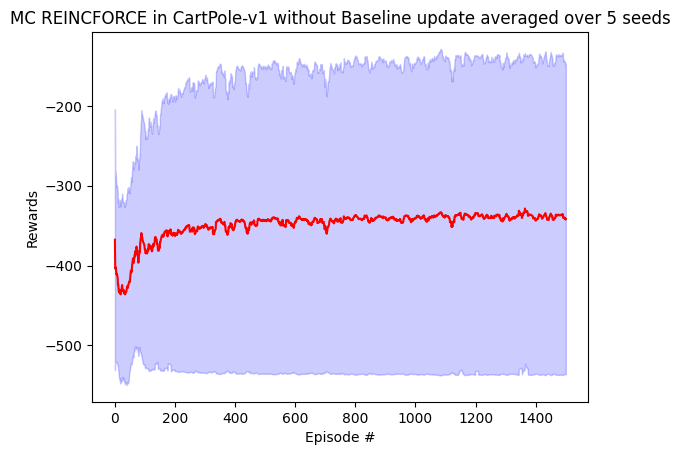

In [78]:
plot_mean_variance_plot(acrobot_no_baseline_avg_scores,env_id=env_id,baseline=False)

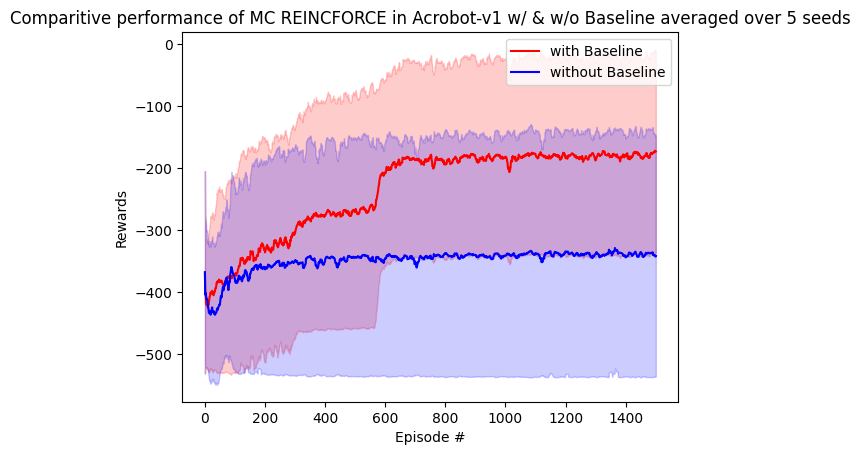

In [68]:
plot_mean_variance_plot(acrobot_baseline_avg_scores,acrobot_no_baseline_avg_scores,env_id=env_id)

# Cartpole - v1

In [72]:
#hyperparameteres
env_id = "CartPole-v1"
lr1 = 1e-3
lr2 = 1e-3
hidden_size = 32
max_episodes = 1500
max_steps = 1000

In [73]:
#running 5 experiments.
np.random.seed(42)
seeds = np.random.randint(1000, size=5)
cartpole_baseline_scores = []
cartpole_baseline_avg_scores = []
exp = 1
for seed in seeds:
  print(f"Experiment {exp} => Training started\n")
  rewards,avg_rewards = run_experiment(env_id,baseline = True ,seed = int(seed),lr1 = lr1,lr2=lr2,print_flag=False,plot_flag = False)
  cartpole_baseline_scores.append(rewards)
  cartpole_baseline_avg_scores.append(avg_rewards)
  exp+=1

Experiment 1 => Training started

Experiment completed! Rewards recorded!
Experiment 2 => Training started

Experiment completed! Rewards recorded!
Experiment 3 => Training started

Experiment completed! Rewards recorded!
Experiment 4 => Training started

Experiment completed! Rewards recorded!
Experiment 5 => Training started

Experiment completed! Rewards recorded!


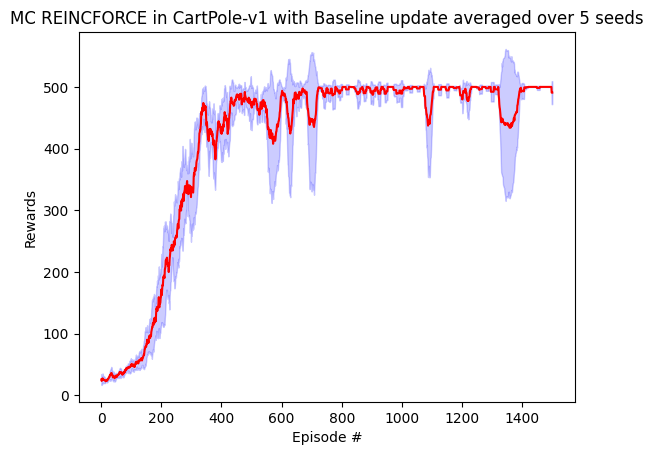

In [74]:
plot_mean_variance_plot(cartpole_baseline_avg_scores,env_id=env_id,baseline=True)

In [75]:
#running 5 experiments.
np.random.seed(42)
seeds = np.random.randint(1000, size=5)
cartpole_no_baseline_scores = []
cartpole_no_baseline_avg_scores = []
exp = 1
for seed in seeds:
  print(f"Experiment {exp} => Training started\n")
  rewards,avg_rewards = run_experiment(env_id,baseline = False ,seed = int(seed),lr1 = lr1,lr2=lr2,print_flag=False,plot_flag = False)
  cartpole_no_baseline_scores.append(rewards)
  cartpole_no_baseline_avg_scores.append(avg_rewards)
  exp+=1

Experiment 1 => Training started

Experiment completed! Rewards recorded!
Experiment 2 => Training started

Experiment completed! Rewards recorded!
Experiment 3 => Training started

Experiment completed! Rewards recorded!
Experiment 4 => Training started

Experiment completed! Rewards recorded!
Experiment 5 => Training started

Experiment completed! Rewards recorded!


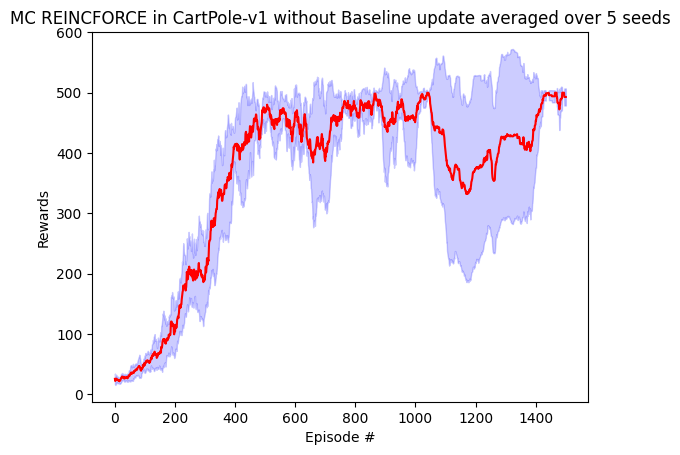

In [76]:
plot_mean_variance_plot(cartpole_no_baseline_avg_scores,env_id=env_id,baseline=False)

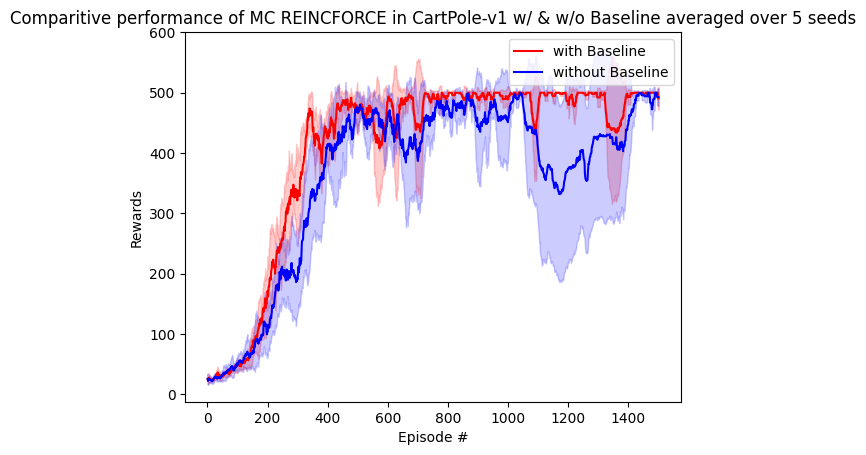

In [77]:
plot_mean_variance_plot(cartpole_baseline_avg_scores,cartpole_no_baseline_avg_scores,env_id=env_id)